In [49]:
from numpy.typing import NDArray  # trying to be typesafe
import numpy as np  # needed all over the place
import scipy
from scipy.stats import skew
from IPython.display import HTML # in line animations

import os   # file and file path

from itertools import count
import pandas as pd
import matplotlib.pyplot as plt  # for plots

from matplotlib import colors  # not quite sure what fore
from matplotlib.ticker import PercentFormatter  # also not sure, maybe animation..?
from matplotlib.animation import FuncAnimation, FFMpegWriter  # for animations

### Funcitons and Objects

In [50]:
def initiate_positions_on_grid(
            num_particles: int,
            box: tuple [int,int],

    ) -> NDArray[np.float32]:
    """
    Initializes 2D positions on a Grid with even spacing.

    Parameters:
        
        n_particles:(int)
                -> number of particles
        
        box:(tuple[number,number]) 
                -> box size (in [nm])
        
    Return:
        (NDArray[float, shpae=(dimension, number of particles)])
                -> list of vectors of positons that are aranged on a grid
    """
    grid_sections = int(np.ceil(np.sqrt(num_particles)))  # find the number of colums & rows
    # even spacing
    x_spacing = box[0]/grid_sections 
    y_spacing = box[1]/grid_sections
    print("x_spacing:",x_spacing)
    print("y_spacing:",y_spacing)
    # makes grid coordinates
    x, y= np.meshgrid(
        np.arange(grid_sections) * x_spacing, 
        np.arange(grid_sections) * y_spacing
    )        # constants

    x= x.flatten()[:num_particles]+ x_spacing/2
    y= y.flatten()[:num_particles]+ y_spacing/2

    positions= np.array([x,y])
    print("init positions: type",type(positions),"size",np.size(positions,axis=0), np.size(positions, axis=1))  
    return positions

In [51]:
def initiate_velocities(
        num_particles: int,
        dimension: int,
        velocity: float
) -> NDArray[np.float64]:
    """
    Initiating random velocities.
    """
    velocities=  (np.random.rand(dimension,num_particles) - 0.5)
    velocities= velocity/np.linalg.norm(velocities) * velocities
    print("init velocities: type",type(velocities),"size",np.size(velocities, axis=0), np.size(velocities, axis=1))
    return velocities

In [52]:
class Particles:
    """
    Container for all particles of a simulation with the same attributes and interactions.

    Fields:

        n: (int)
                -> Number of particles 

        m: (float)
                -> Mass of the paricles

        d: (int)
                -> Dimension in which the particles live

        r: (float)
                -> Radius of particles

        x: (NDArray[np.flaot64, shape=(d,n)]),
                -> Array of positions vectors; All positions

        v: (NDArray[np.flaot32, shape=(d,n)])
                -> Array of velocity vectors; All velocities
    """
    def __init__(
        self,
        number: int,
        mass: float | int,
        velocity: float,
        radius: float | int,
        box: tuple[float|int, float|int]
    ):
        """
        Initiate particles with unpecified positions, velocities, accelerations.
        """
        self.n: int = number
        self.m: float = float(mass)  #  kg
        self.d: int = len(box)
        self.r: float = radius  # nm
        self.box: NDArray[np.float32]= np.array([[0,box[0],0,box[0]],[0,0,box[1],box[1]]])  # nm

        print("ititated",self.n, "particles:\n\tradius",self.r,"\tmass",self.m,"\tdimensions",self.d)

        self.x: NDArray[np.float32]= initiate_positions_on_grid(number,box) 
        self.v: NDArray[np.float32]= initiate_velocities(number, self.d, velocity)

        fig = plt.figure()
        ax = fig.add_subplot()
        ax.set_title("Initiation: Positions")
        ax.scatter(self.x[0,:], self.x[1,:])
        #plt.quiver([self.x[0,:],self.x[1,:]],self.v[0,:],self.v[1,:], pivot="tail")
        ax.grid(True)
        plt.show()      
        plt.close()

In [53]:
def relative_distnace(x_1, x_2, box):
    """
    Determines the minimum relative distance over periodic boundary conditions.

    Parameters:
        x_1: array-like
            Position vector of particle 1 (e.g., [x1, y1]).
        x_2: array-like
            Position vector of particle 2 (e.g., [x2, y2]).
        box: array-like
            Box dimensions (e.g., [Lx, Ly] for a 2D system).

    Returns:
        tuple:
            - NDArray: Relative displacement vector (minimum image).
            - float: Minimum relative distance.
    """
    # Compute the direct displacement vector
    rel_vector = x_1 - x_2

    # Apply minimum image convention
    for dim in range(len(box)):
        rel_vector[dim] -= box[dim] * np.round(rel_vector[dim] / box[dim])

    # Compute the minimum image distance
    distance = np.linalg.norm(rel_vector)

    return rel_vector, distance

In [54]:
def hard_sphere_collision(
        particles:Particles,
):
    for i in range(particles.n):
        for j in range(i+1,particles.n):
            r_rel, d_rel= relative_distnace(particles.x[:,i], particles.x[:,j],particles.box[:,3]) 
            if d_rel-2*particles.r <= 0:
                # print("collision detected!")
                r_pro= r_rel/d_rel
                dv= np.dot((particles.v[:,i]-particles.v[:,j]),r_pro) * r_pro
                particles.v[:,i] -= dv
                particles.v[:,j] += dv

In [55]:
def iterate(
        particles: Particles,
        dt:float
):
    """
    Iterates the particles with elastic collision.

    Parameters:

        particles: (Particles)
                -> particles of the system
        
        dt: (float)
                -> size of time step 
    """
    hard_sphere_collision(particles=particles)
    particles.x+= particles.v*dt  
    # print("box for modulo", particles.box[:,3])
    particles.x = np.mod(particles.x, [[particles.box[0,3]],[particles.box[1,3]]])  # periodic boundry conditions

In [56]:
def simulate(
        particles:Particles,
        Time_steps:int,
        dt:float,
) -> NDArray[np.float32]:
        """
        Simulates the trajectory of hard spheres & elastic collision.

        Parameters:
                particles: (Particles)
                        -> particles that will be simulated
                
                Time_stepps: (int)
                        -> number of time iterations
                
                dt: (float)
                        -> time step size
        
        Return:
                data: (NDArray[float, shape(Time_steps, dimesions, num_particle)])
        """
        data= np.zeros((Time_steps, particles.d, particles.n))
        data[0,:,:]=particles.x
        for t in range(Time_steps):
                iterate(particles=particles,dt=dt)
                # print("\npartice pos",particles.x[:,0])
                data[t,:,:]=particles.x
                # print("pos in data",data[t,:,0],"\n")
        return data

In [57]:
def rdf(particles, data, bin_size):
    """
    Calculates the radial distribution function from a dataset.

    Parameters:
        particles: (Particles)
            -> An object containing particle properties (positions, box size, etc.)

        data: (NDArray)
            -> Simulation data of shape (T, dim, n_particles)

        n_bins: (int)
            -> Number of bins for the RDF histogram.

    Returns:
        tuple: (rdf_values, bin_edges)
            rdf_values: Radial distribution function values.
            bin_edges: The edges of the RDF bins (r values).
    """
    T, dim, n_particles = data.shape
    box_size_x, box_size_y = particles.box[0,3], particles.box[1,3]
    rho = n_particles / (box_size_x * box_size_y)  # Isotropic density in 2D
    max_distance = box_size_x/2 # np.sqrt((box_size_x/2)**2+(box_size_y/2)**2)
    n_bins= int(np.ceil(max_distance/bin_size))
    print("number of bins:",n_bins)
    bin_edges = np.linspace(0, max_distance, n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    rdf_hist = np.zeros(n_bins)
    print("length of r:",len(bin_centers))
    print("length of rdf:",len(rdf_hist))
    for t in range(T):
        distances = []
        for i in range(n_particles):
            for j in range(i + 1, n_particles):
                # Calculate relative distance with PBC
                _, distance = relative_distnace(data[t, :, i], data[t, :, j], particles.box[:,3])
                distances.append(distance)

        # Update histogram for this time step
        hist, _ = np.histogram(distances, bins=bin_edges)
        rdf_hist += hist  # Accumulate histogram over time

    # Normalize RDF
    two_pi_r = 2*np.pi * (bin_edges[1:])
    dn_dr = rdf_hist/bin_size
    rdf_values = dn_dr / (T * n_particles/2 * rho * two_pi_r)

    # Optionally plot
    plt.plot(bin_centers, rdf_values)
    plt.title("Radial Distribution Function")
    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.grid(True)
    plt.show()

    return rdf_values, bin_centers


In [58]:
a=np.array([[[1,2],[2,4],[5,3]],[[2,4], [5,6],[9,10]],[[4,6],[1,9],[5,8]]])
print(np.shape(a))
print(np.mean(a,axis=0))
print(np.mean(np.mean(a,axis=0),axis=0))

(3, 3, 2)
[[2.33333333 4.        ]
 [2.66666667 6.33333333]
 [6.33333333 7.        ]]
[3.77777778 5.77777778]


In [59]:
def mean_kinetik_energy(particles:Particles) -> float:
    """Determines mean kinetik energy of particles"""
    return particles.m/2*np.sum( np.linalg.vecdot( particles.v,particles.v, axis=0))/particles.n

In [60]:
def temperature(particles:Particles) -> float:
    """Determines Temperature of particles in [K]"""
    k_B= 1.38e-23  # J/K
    return mean_kinetik_energy(particles=particles)/k_B

In [61]:
def potential_of_maen_force(temperature:float,rdf:NDArray) -> NDArray:
    k_B= 1.38e-23  # J/K
    return -np.log(rdf)*k_B*temperature

ititated 100 particles:
	radius 0.2 	mass 0.002 	dimensions 2
x_spacing: 1.0
y_spacing: 1.0
init positions: type <class 'numpy.ndarray'> size 2 100
init velocities: type <class 'numpy.ndarray'> size 2 100


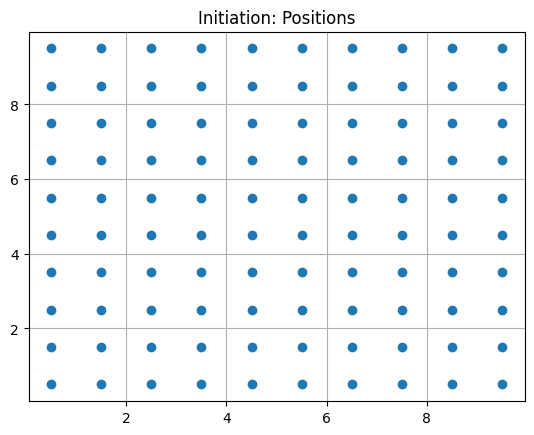

[[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5
  8.5 9.5 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 0.5 1.5 2.5 3.5 4.5 5.5
  6.5 7.5 8.5 9.5 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 0.5 1.5 2.5 3.5
  4.5 5.5 6.5 7.5 8.5 9.5 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 0.5 1.5
  2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5
  1.5 1.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 3.5 3.5 3.5 3.5 3.5 3.5
  3.5 3.5 3.5 3.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 5.5 5.5 5.5 5.5
  5.5 5.5 5.5 5.5 5.5 5.5 6.5 6.5 6.5 6.5 6.5 6.5 6.5 6.5 6.5 6.5 7.5 7.5
  7.5 7.5 7.5 7.5 7.5 7.5 7.5 7.5 8.5 8.5 8.5 8.5 8.5 8.5 8.5 8.5 8.5 8.5
  9.5 9.5 9.5 9.5 9.5 9.5 9.5 9.5 9.5 9.5]]
[1.49788885 0.50313767] [2.4992733  0.50538016]


In [62]:
NUM_PARTICLES = 100
BOX = (10,10)  # [nm]
DIMENSIONS= len(BOX)
TIME = 5000  #  *DT [ns]
DT= 0.1  # [ns]
particles=Particles(
    number=NUM_PARTICLES,
    mass=2*10**(-3),    #  [kg/mol]
    velocity=0.5,       #  [nm/ns]
    radius=0.2,         #  [nm]
    box=BOX
)

print(particles.x)

data= simulate(particles=particles,Time_steps=TIME,dt=DT)
print(data[0,:,1],data[0,:,2])

number of bins: 500
length of r: 500
length of rdf: 500


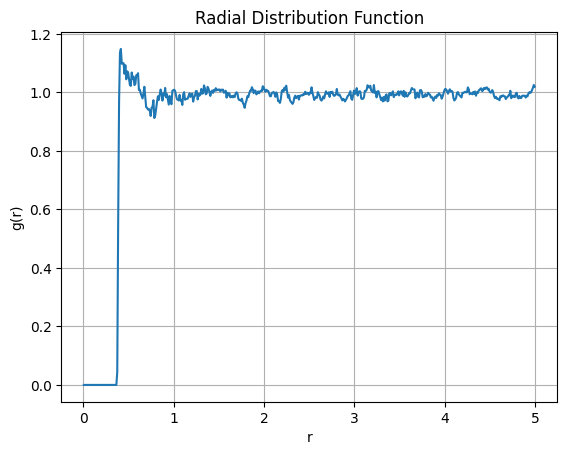

In [63]:
hist, r= rdf(particles=particles, data=data, bin_size=0.01)

(500,) (500,)
1.0198521429374179


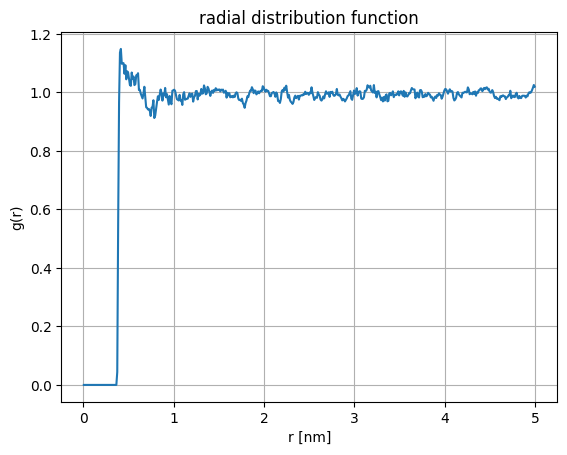

In [64]:
print(np.shape(r),np.shape(hist))
print(hist[-1])
plt.plot(r,hist)
plt.title("radial distribution function")
plt.ylabel("g(r)")
plt.xlabel("r [nm]")
plt.grid(True)
plt.savefig("rdf.png")
plt.show()
plt.close()

/tmp/ipykernel_4425/1827206657.py:3: RuntimeWarning: divide by zero encountered in log
  return -np.log(rdf)*k_B*temperature


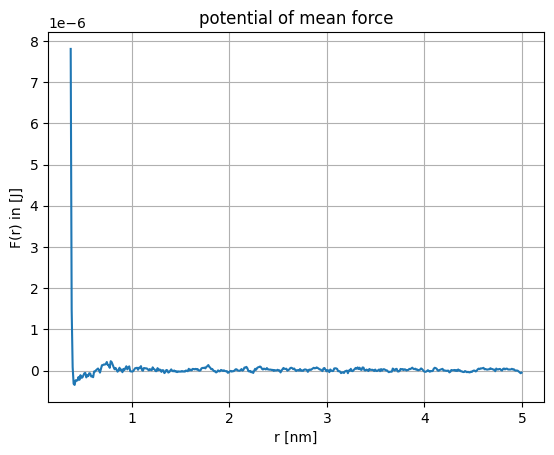

In [65]:
temp=temperature(particles=particles)
pomf=potential_of_maen_force(temperature=temp,rdf=hist)

plt.plot(r,pomf)
plt.title("potential of mean force")
plt.xlabel("r [nm]")
plt.ylabel("F(r) in [J]")
plt.grid(True)
plt.savefig("pot_mean_force.png")
plt.show()
plt.close()

In [66]:
def animate(
        frame,
        data: NDArray[np.float64], 
        scat
):
    """
    Takes x and y data [time, particle]; init funciton for "creat_animation"
    """
    scat.set_offsets(np.c_[data[frame,0,:],data[frame,1,:]])
    return scat,

def animation_plot(
    p_radius: float|int,
    box: tuple[float|int]
):
    """
    takes box size and particle radius. Initation for "creat_animation"
    """
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], s=p_radius)  # Scale size for visibility
    ax.set_xlim(0,box[0])
    ax.set_ylim(0,box[1])
    ax.set_title("Simulation Visualization")
    ax.set_xlabel("X [nm]")
    ax.set_ylabel("Y [nm]")
    plt.grid(True,which="both")
    return scat, fig, ax

def creat_animation(
        animation_box: tuple[int,int],
        particle_drawn_radius: float|int,
        data: NDArray[np.float64],
        save_animation: bool= False,
        animation_name: str= "partilce_simulation",
) -> FuncAnimation: 
    """
    Creats animation for x and y data
    
    Parameters:

        animation_box: (tuple)
            -> simulation box

        particle_drawn_radius: (number)
            -> how big the particles should be drawn

        data: (NDArray[float, shape=(T, dim, num)]) 

    """
    scat, fig, ax = animation_plot(p_radius=particle_drawn_radius, box=animation_box)
    anim = FuncAnimation(fig, 
                        func=animate,
                        frames=len(data[:,0,0]),
                        fargs=(data, scat),
                        interval=10,
                        blit=False
                    )
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Dominic Nieder'), bitrate=1800)
    if save_animation:
        anim.save(animation_name+".mp4")
    return anim

In [ ]:
mp4= creat_animation(BOX,particle_drawn_radius=50, data= data)
HTML(mp4.to_html5_video())